In [5]:
import sys
from pathlib import Path
import re
import pandas as pd

train_subjects = ["01", "02" ,"03", "04", "05", "06", "07", "08"]
test_subjects = ["01", "02" ,"03", "04", "05", "06", "07", "08"]

adl_events = [
    "emptywc",
    "resting",
    "phone",
    "computer",
    "arm_raises",
    "eating",
    # "hand_cycling",
    # "chair_to_bed_transfer",
    # "bed_to_chair_transfer",
    "pressure_relief",
    # "laying_on_back",
    # "laying_on_right",
    # "laying_on_left",
    # "laying_on_stomach",
    # "assisted_propulsion",
    "self_propulsion"
]

# Add src to sys.path for imports
sys.path.insert(0, str(Path.cwd().parent / "src"))
from utils import get_project_root, get_data_path

# Set up paths using utility functions
project_root = get_project_root()
feature_data_dir = get_data_path("features")

def get_files_for_subjects(subject_ids, feature_data_dir):
    # Regex to match patientXX in filename
    pattern = re.compile(r"patient(" + "|".join(subject_ids) + r")@.+@features\.csv$")
    return [f for f in feature_data_dir.iterdir() if pattern.search(f.name)]

def load_and_concat_features(subject_ids, feature_data_dir, adl_events):
    files = get_files_for_subjects(subject_ids, feature_data_dir)
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        m = re.match(r"patient(\d+)@([^@]+)@(\d+)@features\.csv", f.name)
        if m:
            adl_class = m.group(2)
            if adl_class not in adl_events:
                continue  # Skip this ADL if not in the list
            df["patient"] = m.group(1)
            df["ADL_class"] = adl_class
            df["adl_instance"] = m.group(3)
            dfs.append(df)
    return pd.concat(dfs, axis=0, ignore_index=True)


# Load train and test data
train_df = load_and_concat_features(train_subjects, feature_data_dir, adl_events)
test_df = load_and_concat_features(test_subjects, feature_data_dir, adl_events)


print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape, "\n")

print("Train ADL class distribution:\n", train_df["ADL_class"].value_counts().to_string(name=False), "\n")
print("Test ADL class distribution:\n", test_df["ADL_class"].value_counts().to_string(name=False), "\n")

Train shape: (28018, 730)
Test shape: (28018, 730) 

Train ADL class distribution:
 ADL_class
computer           4947
phone              4865
eating             4850
self_propulsion    3275
arm_raises         2757
emptywc            2528
pressure_relief    2438
resting            2358 

Test ADL class distribution:
 ADL_class
computer           4947
phone              4865
eating             4850
self_propulsion    3275
arm_raises         2757
emptywc            2528
pressure_relief    2438
resting            2358 



In [8]:
from sklearn.preprocessing import LabelEncoder

# Drop columns not used for features
drop_cols = ["window_id", "adl_instance", "patient", "ADL_class"]
X_train = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns])
y_train = train_df["ADL_class"]

X_test = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns])
y_test = test_df["ADL_class"]

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Ensure test features match train features in order and content
feature_cols = X_train.columns  # X_train should be defined from your training cell
X_test = X_test.reindex(columns=feature_cols)


In [9]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train_enc)
dtest = xgb.DMatrix(X_test, label=y_test_enc)

params = {
    "objective": "multi:softmax",
    "num_class": len(le.classes_),
    # "eval_metric": "merror",
    # "max_depth": 4,
    "eta": 0.1,
    "seed": 42,
    "device": "cuda",
    "tree_method": "hist",      # Use GPU for training
    # "predictor": "gpu_predictor"    # Use GPU for prediction (optional, for training phase)
}

bst = xgb.train(params, dtrain, num_boost_round=100)

# bst.set_param({'predictor': 'cpu_predictor'})

# Predict
y_pred = bst.predict(dtest)
y_pred_labels = le.inverse_transform(y_pred.astype(int))


Classification Report:
                 precision    recall  f1-score   support

     arm_raises       1.00      1.00      1.00      2757
       computer       1.00      1.00      1.00      4947
         eating       1.00      1.00      1.00      4850
        emptywc       1.00      1.00      1.00      2528
          phone       1.00      1.00      1.00      4865
pressure_relief       1.00      1.00      1.00      2438
        resting       1.00      1.00      1.00      2358
self_propulsion       1.00      1.00      1.00      3275

       accuracy                           1.00     28018
      macro avg       1.00      1.00      1.00     28018
   weighted avg       1.00      1.00      1.00     28018



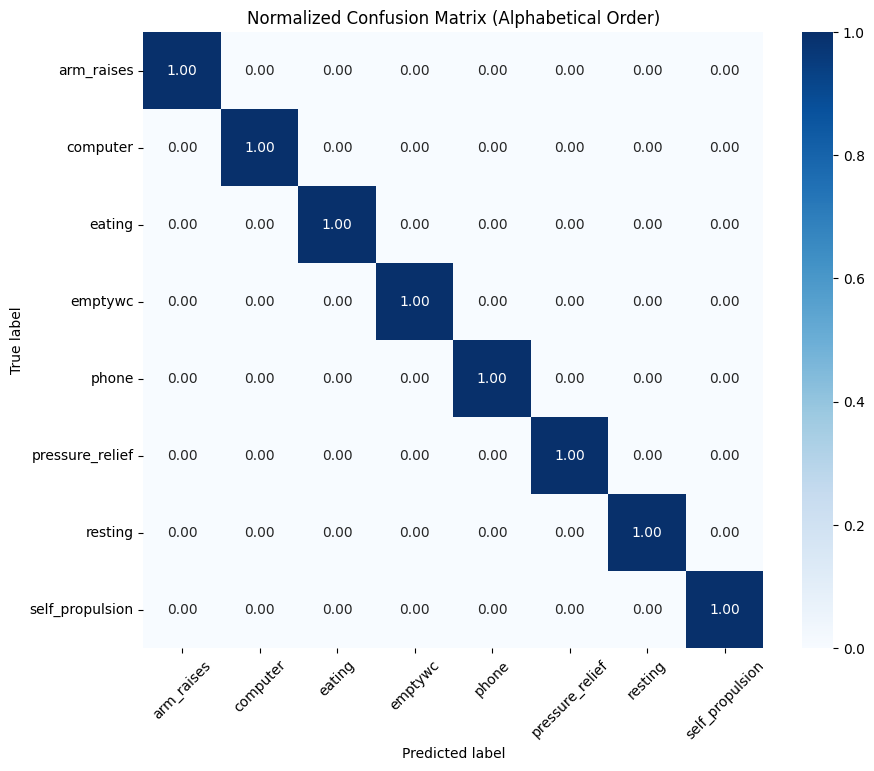

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # Make sure pandas is imported

# Sort labels alphabetically
sorted_labels = sorted(le.classes_)

# Print classification report with sorted labels
print("Classification Report:")
print(classification_report(y_test, y_pred_labels, target_names=sorted_labels))

# Compute normalized confusion matrix with sorted labels
cm = confusion_matrix(y_test, y_pred_labels, labels=sorted_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=sorted_labels, columns=sorted_labels)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues')
plt.xticks(rotation=45)
plt.yticks(rotation=0)  # Or rotate if needed
plt.title('Normalized Confusion Matrix (Alphabetical Order)')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()


In [12]:
import joblib
from pathlib import Path

# Define the models directory using project_root
models_dir = project_root / "data" / "models"
models_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

# Save XGBoost model
bst.save_model(str(models_dir / "xgb_model.json"))

# Save label encoder
joblib.dump(le, str(models_dir / "label_encoder.pkl"))

['/scai_data3/scratch/ejtehadi_m/ros-adl-classifier/data/models/label_encoder.pkl']